En este notebook se desarrollan los gráficos que se usarán en la parte de resultados del TFM

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from src.datasets import daocensus, daocensus_text, to_microsoft
from src import paths

In [2]:
ORG_NAME = 'Decentraland'
ORG_PLATFORM = 'snapshot'
USE_ORG_NAMES: bool = False
CUTOFF_DATE_STR: str = None
LAST_SPLITS = ... # Wont be used

SPLITS_FREQ = 'W-THU'
SPLITS_NORMALIZE: bool = True

In [3]:
# Parameters
ORG_NAME = "PancakeSwap"
ORG_PLATFORM = "snapshot"
SPLITS_FREQ = "3d"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-21"
CUTOFF_DATE_STR = "2023-07-01"


In [4]:
CUTOFF_DATE = dt.datetime.fromisoformat(CUTOFF_DATE_STR) if CUTOFF_DATE_STR else None

# Exploración de datos de Decentraland

In [5]:
# dfptext = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, ORG_PLATFORM)
# dfv['voter'] = dfv['voter'].astype('str')
# dfp = dfp.merge(dfptext, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')
# dfp = dfp.set_index('id')
dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES, cutoff_date=CUTOFF_DATE)
dfp = dfp.set_index('id')
print(dfv.info())
print(dfp.info())

Warning, removing 529464 votes without proposal


<class 'pandas.core.frame.DataFrame'>
Int64Index: 529464 entries, 0 to 529463
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   platform       529464 non-null  object        
 1   name           529464 non-null  object        
 2   id             529464 non-null  object        
 3   proposal       529464 non-null  category      
 4   deployment     529464 non-null  object        
 5   platform_vote  529464 non-null  object        
 6   voter          529464 non-null  category      
 7   date           529464 non-null  datetime64[ns]
 8   choice         529464 non-null  object        
 9   weight         529464 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 40.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 2684 entries, 7052d3a8-bc93-5b3a-a69c-be0512b72483 to c7f2acb7-d0c4-540d-85bf-677b0e08952e
Data columns (total 12 colum

## Cuantas propuestas tenemos para entrenar en el dataset

In [6]:
from src.model_selection import timeFreqSplitCurrent, filter_current
from collections import defaultdict

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in timeFreqSplitCurrent(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['t'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('t')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
sdf = sdf_all.tail(10)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

t
2023-05-31    516030
2023-06-03    518406
2023-06-06    519004
2023-06-09    519741
2023-06-12    521180
2023-06-15    522447
2023-06-18    524648
2023-06-21    525836
2023-06-24    527714
2023-06-27    528366
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
t,,,,,,,,,
2023-W22,88,4334,2359,49.25,1.84,1374,489,15.61,2.81
2023-W22,64,2312,1090,36.12,2.12,859,314,13.42,2.74
2023-W23,66,2660,1158,40.30,2.30,664,276,10.06,2.41
2023-W23,73,2951,1159,40.42,2.55,508,241,6.96,2.11
2023-W24,59,2137,869,36.22,2.46,436,214,7.39,2.04
2023-W24,101,2927,1176,28.98,2.49,593,280,5.87,2.12
2023-W24,90,2811,1197,31.23,2.35,303,126,3.37,2.40
2023-W25,126,3205,1309,25.44,2.45,490,151,3.89,3.25
2023-W25,75,3501,1564,46.68,2.24,641,293,8.55,2.19


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
t &  &  &  &  &  &  &  &  &  \\
2023-W22 & 88 & 4334 & 2359 & 49.25 & 1.84 & 1374 & 489 & 15.61 & 2.81 \\
2023-W22 & 64 & 2312 & 1090 & 36.12 & 2.12 & 859 & 314 & 13.42 & 2.74 \\
2023-W23 & 66 & 2660 & 1158 & 40.30 & 2.30 & 664 & 276 & 10.06 & 2.41 \\
2023-W23 & 73 & 2951 & 1159 & 40.42 & 2.55 & 508 & 241 & 6.96 & 2.11 \\
2023-W24 & 59 & 2137 & 869 & 36.22 & 2.46 & 436 & 214 & 7.39 & 2.04 \\
2023-W24 & 101 & 2927 & 1176 & 28.98 & 2.49 & 593 & 280 & 5.87 & 2.12 \\
2023-W24 & 90 & 2811 & 1197 & 31.23 & 2.35 & 303 & 126 & 3.37 & 2.40 \\
2023-W25 & 126 & 3205 & 1309 & 25.44 & 2.45 & 490 & 151 & 3.89 & 3.25 \\
2023-W25 & 75 & 3501 & 1564 & 46.68 & 2.24 & 641 & 293 & 8.55 & 2.19 \\

In [9]:
sdf.describe()

,open proposals,proposals in train,votes in train,votes in open proposals (train),users in open proposals (train),votes in test,users in train,users in test,vpp in open proposals (train),vpu in open proposals (train),vpp test,vpu test
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000
mean,79.900000,2534.900000,522337.200000,2915.200000,1295.600000,603.300000,128289.700000,244.60000,37.524956,2.293749,7.801310,2.471320
std,21.645887,107.798629,4180.305087,653.913994,413.330699,332.794247,577.601949,118.43817,7.522128,0.215331,4.241785,0.387823
min,57.000000,2415.000000,516030.000000,2137.000000,869.000000,165.000000,127525.000000,62.00000,25.436508,1.837219,2.894737,2.037383
25%,64.500000,2447.250000,519188.250000,2400.500000,1107.000000,449.500000,127839.500000,166.75000,32.456250,2.174041,4.384488,2.135321
50%,74.000000,2500.000000,521813.500000,2869.000000,1167.500000,550.500000,128124.000000,258.50000,38.261685,2.322717,7.174367,2.405280
75%,89.500000,2641.000000,525539.000000,3141.500000,1281.000000,658.250000,128802.000000,289.75000,40.553533,2.456470,9.682121,2.717074
max,126.000000,2681.000000,528366.000000,4334.000000,2359.000000,1374.000000,129119.000000,489.00000,49.250000,2.546160,15.613636,3.245033


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '2023-W22'),
  Text(1, 0, '2023-W22'),
  Text(2, 0, '2023-W23'),
  Text(3, 0, '2023-W23'),
  Text(4, 0, '2023-W24'),
  Text(5, 0, '2023-W24'),
  Text(6, 0, '2023-W24'),
  Text(7, 0, '2023-W25'),
  Text(8, 0, '2023-W25'),
  Text(9, 0, '2023-W26')])

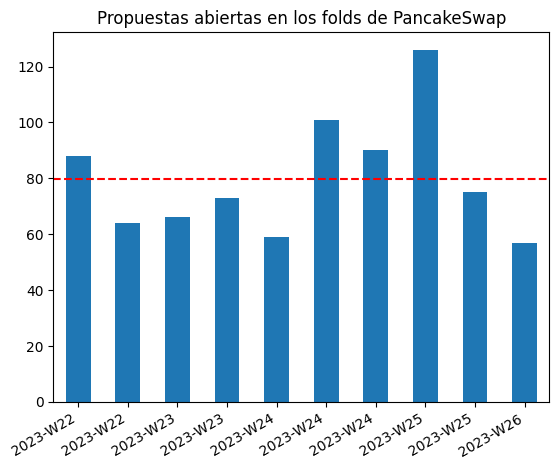

In [10]:
ax = sdf[['open proposals']].plot.bar(legend=False, xlabel='')
plt.axhline(sdf['open proposals'].mean(), c='red', linestyle='--')
ax.set_title(f'Propuestas abiertas en los folds de {ORG_NAME}')
ax.set_xticklabels(sdf.index.strftime('%G-W%V'))
plt.xticks(rotation=30, ha='right')
# TODO: Pintar horizonte con la media

<Axes: xlabel='t'>

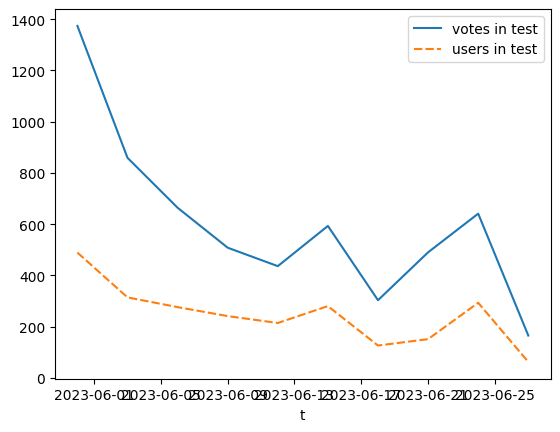

In [11]:
sns.lineplot(sdf[[
    # 'users in train (filtered)', 'votes in train (filtered)', 
    'votes in test', 'users in test',
]])

### Numero de propuestas relevantes
Además del número de propuestas abiertas, queremos saber cual es la _precision@k_ máxima, para ello es necesario saber no sólo el número de propuestas abiertas, si no en cuantas de esas propuestas votaron los usuarios. En términos de IR, necesitamos saber cual es el número de documentos relevantes, que seguramente sea menor que el número de documentos recuperados.

In [12]:
sdf['vpu in test'] = sdf['votes in test'] / sdf['users in test']
sdf

/tmp/ipykernel_459017/710207913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['vpu in test'] = sdf['votes in test'] / sdf['users in test']


,open proposals,proposals in train,votes in train,votes in open proposals (train),users in open proposals (train),votes in test,users in train,users in test,vpp in open proposals (train),vpu in open proposals (train),vpp test,vpu test,vpu in test
t,,,,,,,,,,,,,
2023-05-31,88,2415,516030,4334,2359,1374,127525,489,49.250000,1.837219,15.613636,2.809816,2.809816
2023-06-03,64,2429,518406,2312,1090,859,127778,314,36.125000,2.121101,13.421875,2.735669,2.735669
2023-06-06,66,2443,519004,2660,1158,664,127829,276,40.303030,2.297064,10.060606,2.405797,2.405797
2023-06-09,73,2460,519741,2951,1159,508,127871,241,40.424658,2.546160,6.958904,2.107884,2.107884
2023-06-12,59,2470,521180,2137,869,436,128041,214,36.220339,2.459148,7.389831,2.037383,2.037383
2023-06-15,101,2530,522447,2927,1176,593,128207,280,28.980198,2.488946,5.871287,2.117857,2.117857
2023-06-18,90,2578,524648,2811,1197,303,128613,126,31.233333,2.348371,3.366667,2.404762,2.404762
2023-06-21,126,2662,525836,3205,1309,490,128865,151,25.436508,2.448434,3.888889,3.245033,3.245033
2023-06-24,75,2681,527714,3501,1564,641,129049,293,46.680000,2.238491,8.546667,2.187713,2.187713


# Recomendador GNN

In [13]:
dfh = pd.read_csv(paths.hybrid_results(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, cutoff_date=CUTOFF_DATE))
dfg = dfh[dfh['model'] == 'gnn'].reset_index(drop=True)
dfg

,t,merge,map@10,map@5,ndcg@10,ndcg@5,precision@10,precision@5,recall@10,recall@5,model
0,2023-05-31,-,0.187586,0.184341,0.206312,0.199763,0.035787,0.054806,0.228367,0.205535,gnn
1,2023-06-03,-,0.026679,0.017720,0.059412,0.039052,0.032484,0.027389,0.100758,0.035316,gnn
2,2023-06-06,-,0.035489,0.026345,0.071758,0.052444,0.035507,0.034783,0.119150,0.055091,gnn
3,2023-06-09,-,0.043067,0.026661,0.086476,0.046934,0.037344,0.026556,0.187272,0.086285,gnn
4,2023-06-12,-,0.055224,0.047393,0.094490,0.079217,0.036449,0.046729,0.158947,0.114136,gnn
5,2023-06-15,-,0.330340,0.326051,0.352136,0.342374,0.052143,0.087857,0.389971,0.365118,gnn
6,2023-06-18,-,0.045473,0.042076,0.082444,0.077054,0.030952,0.044444,0.145989,0.124992,gnn
7,2023-06-21,-,0.026709,0.022158,0.048009,0.036915,0.021854,0.021192,0.061167,0.032066,gnn
8,2023-06-24,-,0.322930,0.318693,0.353871,0.346686,0.076109,0.135154,0.406987,0.385619,gnn
9,2023-06-27,-,0.102507,0.070646,0.199777,0.135943,0.082258,0.080645,0.379666,0.190572,gnn


# Recomendador Híbrido

In [14]:
from src import baseline

# dfm_baseline = pd.read_csv(f'./data/baseline/mp-freq-{ORG_NAME}-{SPLITS_FREQ}.csv')
dfm_baseline = baseline.read_metrics_baseline(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, cutoff_date = CUTOFF_DATE)
dfm_baseline['model'] = 'mp'
dfm_all = pd.read_csv(paths.hybrid_results(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, cutoff_date=CUTOFF_DATE)).set_index('t')
dfm_all = pd.concat((dfm_all, dfm_baseline))
dfm_all

,merge,map@10,map@5,ndcg@10,ndcg@5,precision@10,precision@5,recall@10,recall@5,model,precision@15,ndcg@15,map@15,recall@15
t,,,,,,,,,,,,,,
2023-05-31,avg,0.041966,0.068201,0.097753,0.115799,0.039877,0.058896,0.254591,0.219732,hybrid,NaN,NaN,NaN,NaN
2023-06-03,avg,0.057247,0.051981,0.095082,0.088080,0.042357,0.055414,0.144419,0.091671,hybrid,NaN,NaN,NaN,NaN
2023-06-06,avg,0.052805,0.055655,0.093999,0.086747,0.043116,0.049275,0.158729,0.101901,hybrid,NaN,NaN,NaN,NaN
2023-06-09,avg,0.074059,0.050192,0.109758,0.072755,0.033610,0.033195,0.180437,0.088179,hybrid,NaN,NaN,NaN,NaN
2023-06-12,avg,0.070296,0.037549,0.122512,0.070078,0.047664,0.051402,0.217605,0.094618,hybrid,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-17 23:49:44,NaN,0.018561,0.015414,0.033327,0.025878,0.014762,0.015238,0.045535,0.024958,mp,0.018413,0.048997,0.023429,0.095110
2023-06-20 23:20:15,NaN,0.017181,0.013877,0.032777,0.025549,0.015812,0.017094,0.046501,0.025631,mp,0.019943,0.049570,0.022559,0.098297
2023-06-23 23:57:05,NaN,0.385905,0.380219,0.415198,0.402482,0.086436,0.155851,0.462912,0.428426,mp,0.060461,0.418682,0.387149,0.473889
